In [1]:
import sys
import os
from pathlib import Path

from dateutil.parser import parse
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import BaggingRegressor, BaggingClassifier, GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold, SelectKBest, RFE
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder


if (dir := str(Path(os.getcwd()).parent)) not in sys.path:
    sys.path.append(dir)


from mylib.metrics import Metrics


np.random.seed(73)

In [2]:
wine = pd.read_csv('../data/winequality.csv', sep=';')
rain = pd.read_csv('../data/weatherAUS.csv', sep=',')

In [3]:
print_r_metrics = lambda true, pred: Metrics(true, pred)()

## Wine

In [4]:
wine

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,5,red
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,5,red
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,6,red
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,5,red
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,6,white
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,5,white
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,6,white
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,7,white


In [5]:
wine.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
wine type               0
dtype: int64

In [6]:
X_wine = wine.drop(['quality'], axis=1)
y_wine = wine['quality']
print(X_wine.shape, y_wine.shape)

X_wine_train, X_wine_test, y_wine_train, y_wine_test = train_test_split(X_wine, y_wine, test_size=0.33, stratify=y_wine)

(6497, 12) (6497,)


In [7]:
cols = wine.columns
num_wine = list(set(cols) - {'wine type', 'quality'})
cat_wine = ['wine type']

In [8]:
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), num_wine),
    ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_wine)
], remainder='passthrough')

In [9]:
X_wine_train = preprocessor.fit_transform(X_wine_train)
X_wine_test = preprocessor.transform(X_wine_test)

In [10]:
def test_wine(X_train, y_train, X_test, y_test):
    model = BaggingRegressor().fit(X_train, y_train)
    print_r_metrics(y_test, model.predict(X_test))
    # model = BaggingClassifier().fit(X_train, y_train)
    # print(classification_report(y_test, model.predict(X_test)))
    return model

In [189]:
test_wine(X_wine_train, y_wine_train, X_wine_test, y_wine_test)

MAE:	0.47463869463869457
MSE:	0.42724941724941723
RMSE:	0.6536431880234179
MAPE:	0.08531342731342731
R^2:	0.4411264295335825


BaggingRegressor()

In [190]:
np.std(X_wine_train, axis=0)

array([1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 0.43140899])

In [191]:
X_wine_train.shape

(4352, 12)

In [192]:
vt_wine = VarianceThreshold(0.5)
X_wine_train_vt = vt_wine.fit_transform(X_wine_train)
X_wine_test_vt = vt_wine.transform(X_wine_test)

display(X_wine_train_vt.shape, X_wine_test_vt.shape)

test_wine(X_wine_train_vt, y_wine_train, X_wine_test_vt, y_wine_test)

(4352, 11)

(2145, 11)

MAE:	0.4631235431235431
MSE:	0.41843356643356644
RMSE:	0.6468644111663328
MAPE:	0.08332915232915233
R^2:	0.45265820891873165


BaggingRegressor()

In [193]:
skb_wine = SelectKBest(k=9)
X_wine_train_skb = skb_wine.fit_transform(X_wine_train, y_wine_train)
X_wine_test_skb = skb_wine.transform(X_wine_test)

display(X_wine_train_skb.shape, X_wine_test_skb.shape)

test_wine(X_wine_train_skb, y_wine_train, X_wine_test_skb, y_wine_test)

(4352, 9)

(2145, 9)

MAE:	0.47794871794871785
MSE:	0.4323356643356643
RMSE:	0.6575223679356196
MAPE:	0.08572325822325821
R^2:	0.4344732453404584


BaggingRegressor()

In [23]:
skb_wine = SelectKBest(k=3)
X_wine_train_skb = skb_wine.fit_transform(X_wine_train, y_wine_train)
X_wine_test_skb = skb_wine.transform(X_wine_test)

display(X_wine_train_skb.shape, X_wine_test_skb.shape)

test_wine(X_wine_train_skb, y_wine_train, X_wine_test_skb, y_wine_test)

(4352, 3)

(2145, 3)

MAE:	0.5296011766011766
MSE:	0.5475423031730173
RMSE:	0.7399610146305123
MAPE:	0.09502620897620898
R^2:	0.28377451296306655


BaggingRegressor()

In [194]:
rfe_wine = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=9, step=1)
X_wine_train_rfe = rfe_wine.fit_transform(X_wine_train, y_wine_train)
X_wine_test_rfe = rfe_wine.transform(X_wine_test)

display(X_wine_train_rfe.shape, X_wine_test_rfe.shape)

test_wine(X_wine_train_rfe, y_wine_train, X_wine_test_rfe, y_wine_test)

(4352, 9)

(2145, 9)

MAE:	0.4661072261072261
MSE:	0.41797668997668996
RMSE:	0.6465111677122755
MAPE:	0.08401814851814851
R^2:	0.4532558368297547


BaggingRegressor()

In [25]:
rfe_wine = RFE(estimator=GradientBoostingRegressor(), n_features_to_select=3, step=1)
X_wine_train_rfe = rfe_wine.fit_transform(X_wine_train, y_wine_train)
X_wine_test_rfe = rfe_wine.transform(X_wine_test)

display(X_wine_train_rfe.shape, X_wine_test_rfe.shape)

test_wine(X_wine_train_rfe, y_wine_train, X_wine_test_rfe, y_wine_test);

(4352, 3)

(2145, 3)

MAE:	0.5306789136789135
MSE:	0.5257361885278155
RMSE:	0.7250766776885156
MAPE:	0.09479877943925562
R^2:	0.3122985100891986


In [212]:
pca_wine = PCA(n_components=9)
X_wine_train_pca = pca_wine.fit_transform(X_wine_train, y_wine_train)
X_wine_test_pca = pca_wine.transform(X_wine_test)

display(X_wine_train_pca.shape, X_wine_test_pca.shape)

test_wine(X_wine_train_pca, y_wine_train, X_wine_test_pca, y_wine_test)

display(np.sum(pca_wine.explained_variance_ratio_))

(4352, 9)

(2145, 9)

MAE:	0.4768298368298368
MSE:	0.4373240093240093
RMSE:	0.6613047779382887
MAPE:	0.08602393902393901
R^2:	0.42794812427112483


0.9737300744288794

In [27]:
pca_wine = PCA(n_components=3)
X_wine_train_pca = pca_wine.fit_transform(X_wine_train, y_wine_train)
X_wine_test_pca = pca_wine.transform(X_wine_test)

test_wine(X_wine_train_pca, y_wine_train, X_wine_test_pca, y_wine_test)

display(np.sum(pca_wine.explained_variance_ratio_));

MAE:	0.5377622377622377
MSE:	0.5441911421911422
RMSE:	0.7376931219627455
MAPE:	0.09706713656713656
R^2:	0.28815807728763754


0.6451788172539792

In [28]:
tsne_wine = TSNE(n_components=3)
X_wine_train_tsne = tsne_wine.fit_transform(X_wine_train, y_wine_train)
X_wine_test_tsne = tsne_wine.fit_transform(X_wine_test)

test_wine(X_wine_train_tsne, y_wine_train, X_wine_test_tsne, y_wine_test);

MAE:	0.706946386946387
MSE:	0.8024335664335664
RMSE:	0.8957865629900721
MAPE:	0.12489867539867539
R^2:	-0.049641952052165816


In [228]:
isomap_wine = Isomap(n_components=9)
X_wine_train_isomap = isomap_wine.fit_transform(X_wine_train, y_wine_train)
X_wine_test_isomap = isomap_wine.transform(X_wine_test)

display(X_wine_train_isomap.shape, X_wine_test_isomap.shape)

test_wine(X_wine_train_isomap, y_wine_train, X_wine_test_isomap, y_wine_test);

(4352, 9)

(2145, 9)

MAE:	0.48400932400932395
MSE:	0.44476456876456877
RMSE:	0.6669067166887501
MAPE:	0.08712829762829762
R^2:	0.41821532686303486


BaggingRegressor()

In [29]:
isomap_wine = Isomap(n_components=3)
X_wine_train_isomap = isomap_wine.fit_transform(X_wine_train, y_wine_train)
X_wine_test_isomap = isomap_wine.transform(X_wine_test)

test_wine(X_wine_train_isomap, y_wine_train, X_wine_test_isomap, y_wine_test);

MAE:	0.5245687645687644
MSE:	0.53016317016317
RMSE:	0.728123046032173
MAPE:	0.09471293521293521
R^2:	0.3065076934536418


## Rain

In [4]:
display(rain['RainTomorrow'].value_counts())

rain0 = rain[rain['RainTomorrow'] == 'No']
rain1 = rain[rain['RainTomorrow'] == 'Yes']

rain0 = resample(rain0,
                 replace=False,
                 n_samples=len(rain1),
                 random_state=73)

rain = pd.concat([rain1, rain0])
display(rain['RainTomorrow'].value_counts())

No     110316
Yes     31877
Name: RainTomorrow, dtype: int64

Yes    31877
No     31877
Name: RainTomorrow, dtype: int64

In [5]:
rain['Date'] = rain['Date'].apply(parse)
rain['Day'] = rain['Date'].apply(lambda x: x.day)
rain['Month'] = rain['Date'].apply(lambda x: x.month)
rain.drop(columns=['Date'], inplace=True)
rain.head(3)

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,Day,Month
8,Albury,9.7,31.9,0.0,NaN,NaN,NNW,80.0,SE,NW,...,1008.9,1003.6,NaN,NaN,18.3,30.2,No,Yes,9,12
10,Albury,13.4,30.4,0.0,NaN,NaN,N,30.0,SSE,ESE,...,1011.8,1008.7,NaN,NaN,20.4,28.8,No,Yes,11,12
11,Albury,15.9,21.7,2.2,NaN,NaN,NNE,31.0,NE,ENE,...,1010.5,1004.2,8.0,8.0,15.9,17.0,Yes,Yes,12,12


In [6]:
rain.isna().sum()

Location             0
MinTemp            295
MaxTemp            136
Rainfall           874
Evaporation      27528
Sunshine         30366
WindGustDir       4429
WindGustSpeed     4398
WindDir9am        4153
WindDir3pm        1833
WindSpeed9am       622
WindSpeed3pm      1251
Humidity9am        872
Humidity3pm       1743
Pressure9am       6240
Pressure3pm       6248
Cloud9am         23563
Cloud3pm         24794
Temp9am            444
Temp3pm           1336
RainToday          874
RainTomorrow         0
Day                  0
Month                0
dtype: int64

In [6]:
rain = rain.drop(columns=['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm'])

In [7]:
num_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
                'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
                'Temp9am', 'Temp3pm', 'Day', 'Month']
cat_features = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', 'RainToday']
target_feature = 'RainTomorrow'

num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

rain_preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features),
], remainder='passthrough')

In [8]:
X_rain = rain.drop([target_feature], axis=1)
y_rain = rain[target_feature]

y_rain = y_rain.map({'Yes': 1, 'No': 0})

print(X_rain.shape, y_rain.shape)

X_rain_train, X_rain_test, y_rain_train, y_rain_test = train_test_split(X_rain, y_rain, test_size=0.33, stratify=y_rain)

(63754, 19) (63754,)


In [62]:
X_rain_train

,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,Day,Month
111344,Albany,6.8,15.3,9.8,NaN,NaN,WSW,NaN,61.0,NaN,74.0,NaN,1009.2,1011.5,11.8,NaN,Yes,2,10
27294,Richmond,7.8,21.0,0.0,SW,30.0,SSW,SE,2.0,13.0,80.0,53.0,1028.2,1024.8,14.6,19.5,No,8,5
81246,Dartmoor,4.8,13.8,0.0,NW,46.0,NNE,NNW,22.0,20.0,67.0,73.0,1007.5,1002.2,10.6,13.0,No,6,9
11923,CoffsHarbour,22.4,31.8,0.0,SSW,39.0,ENE,SSW,7.0,28.0,71.0,72.0,1010.0,1011.5,27.6,28.7,No,2,2
73398,Mildura,-0.5,16.7,0.0,NNE,24.0,SE,NNE,6.0,13.0,99.0,51.0,1028.2,1024.4,3.8,16.1,No,22,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35761,SydneyAirport,14.8,25.4,2.0,NNW,33.0,NW,NNW,13.0,11.0,68.0,43.0,1015.8,1013.0,18.7,24.8,Yes,20,5
108027,Woomera,24.2,36.3,0.0,NE,44.0,E,NNE,17.0,15.0,12.0,15.0,1012.6,1009.6,28.4,35.4,No,30,12
94035,Townsville,23.9,28.8,72.2,N,50.0,NE,NNE,19.0,26.0,94.0,85.0,1003.7,1001.3,26.2,27.9,Yes,26,12
129475,Walpole,11.0,16.8,0.2,NW,46.0,N,NW,17.0,20.0,81.0,83.0,1008.9,1006.7,13.1,16.1,No,28,6


In [9]:
X_rain_train = rain_preprocessor.fit_transform(X_rain_train)
X_rain_test = rain_preprocessor.transform(X_rain_test)

In [10]:
display(X_rain_train.shape, X_rain_test.shape)

(42715, 19)

(21039, 19)

In [11]:
def test_rain(X_train, y_train, X_test, y_test):
    model = BaggingClassifier().fit(X_train, y_train)
    print(classification_report(y_test, model.predict(X_test)))
    return model

In [50]:
test_rain(X_rain_train, y_rain_train, X_rain_test, y_rain_test);

              precision    recall  f1-score   support

          No       0.75      0.82      0.78     10520
         Yes       0.80      0.73      0.76     10519

    accuracy                           0.77     21039
   macro avg       0.78      0.77      0.77     21039
weighted avg       0.78      0.77      0.77     21039



In [51]:
np.std(X_rain_train, axis=1)

array([4.82468869, 4.56970442, 4.71672768, ..., 3.63765414, 1.67467339,
       6.68556988])

In [65]:
vt_rain = VarianceThreshold(1)
X_rain_train_vt = vt_rain.fit_transform(X_rain_train)
X_rain_test_vt = vt_rain.transform(X_rain_test)

display(X_rain_train_vt.shape, X_rain_test_vt.shape)

test_rain(X_rain_train_vt, y_rain_train, X_rain_test_vt, y_rain_test);

(42715, 10)

(21039, 10)

              precision    recall  f1-score   support

          No       0.73      0.80      0.77     10519
         Yes       0.78      0.71      0.74     10520

    accuracy                           0.75     21039
   macro avg       0.76      0.75      0.75     21039
weighted avg       0.76      0.75      0.75     21039



In [70]:
skb_rain = SelectKBest(k=2)
X_rain_train_skb = skb_rain.fit_transform(X_rain_train, y_rain_train)
X_rain_test_skb = skb_rain.transform(X_rain_test)

display(X_rain_train_skb.shape, X_rain_test_skb.shape)

test_rain(X_rain_train_skb, y_rain_train, X_rain_test_skb, y_rain_test);

(42715, 2)

(21039, 2)

              precision    recall  f1-score   support

           0       0.71      0.80      0.75     10519
           1       0.77      0.68      0.72     10520

    accuracy                           0.74     21039
   macro avg       0.74      0.74      0.74     21039
weighted avg       0.74      0.74      0.74     21039



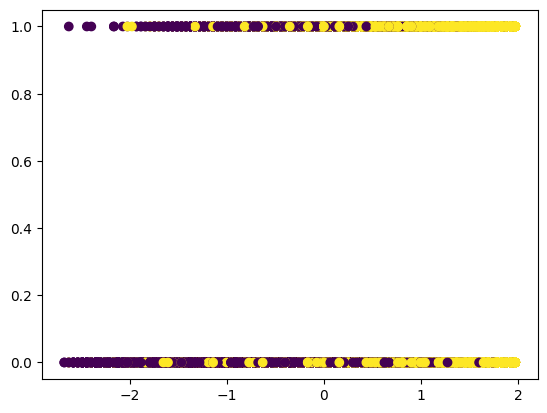

In [74]:
plt.scatter(X_rain_train_skb[:, 0], X_rain_train_skb[:, 1], c=y_rain_train);

In [26]:
rfe_rain = RFE(estimator=GradientBoostingClassifier(), n_features_to_select=2, step=1)
X_rain_train_rfe = rfe_rain.fit_transform(X_rain_train, y_rain_train)
X_rain_test_rfe = rfe_rain.transform(X_rain_test)

display(X_rain_train_rfe.shape, X_rain_test_rfe.shape)

test_rain(X_rain_train_rfe, y_rain_train, X_rain_test_rfe, y_rain_test);

(42715, 2)

(21039, 2)

              precision    recall  f1-score   support

           0       0.73      0.76      0.74     10520
           1       0.75      0.72      0.73     10519

    accuracy                           0.74     21039
   macro avg       0.74      0.74      0.74     21039
weighted avg       0.74      0.74      0.74     21039



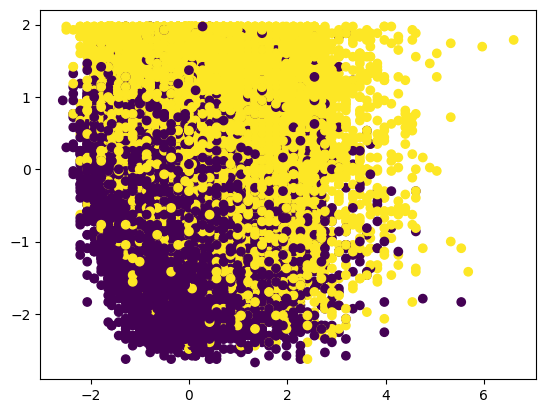

In [27]:
plt.scatter(X_rain_train_rfe[:, 0], X_rain_train_rfe[:, 1], c=y_rain_train);

In [45]:
pca_rain = PCA(n_components=6)
X_rain_train_pca = pca_rain.fit_transform(X_rain_train, y_rain_train)
X_rain_test_pca = pca_rain.transform(X_rain_test)

display(X_rain_train_pca.shape, X_rain_test_pca.shape)

test_rain(X_rain_train_pca, y_rain_train, X_rain_test_pca, y_rain_test);

display(np.sum(pca_rain.explained_variance_ratio_))

(42715, 6)

(21039, 6)

              precision    recall  f1-score   support

          No       0.69      0.77      0.72     10520
         Yes       0.73      0.65      0.69     10519

    accuracy                           0.71     21039
   macro avg       0.71      0.71      0.71     21039
weighted avg       0.71      0.71      0.71     21039



0.9744241920552227

In [84]:
tsne_rain = TSNE(n_components=2)
X_rain_train_tsne = tsne_rain.fit_transform(X_rain_train, y_rain_train)
X_rain_test_tsne = tsne_rain.fit_transform(X_rain_test)

display(X_rain_train_tsne.shape, X_rain_test_tsne.shape)

test_rain(X_rain_train_tsne, y_rain_train, X_rain_test_tsne, y_rain_test)

(42715, 2)

(21039, 2)

              precision    recall  f1-score   support

           0       0.50      0.53      0.51     10519
           1       0.50      0.47      0.48     10520

    accuracy                           0.50     21039
   macro avg       0.50      0.50      0.50     21039
weighted avg       0.50      0.50      0.50     21039



BaggingClassifier()

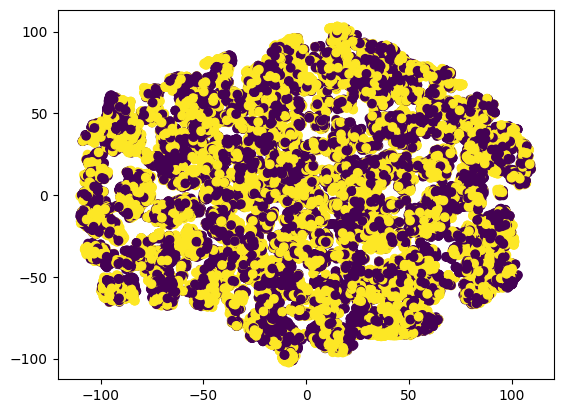

In [85]:
plt.scatter(X_rain_train_tsne[:, 0], X_rain_train_tsne[:, 1], c=y_rain_train);

In [76]:
isomap_rain = Isomap(n_components=3)
X_rain_train_isomap = isomap_rain.fit_transform(X_rain_train[:8000], y_rain_train[:8000])
X_rain_test_isomap = isomap_rain.transform(X_rain_test[:8000])

display(X_rain_train_isomap.shape, X_rain_test_isomap.shape)

test_rain(X_rain_train_isomap, y_rain_train[:8000], X_rain_test_isomap, y_rain_test[:8000]);

(8000, 3)

(8000, 3)

              precision    recall  f1-score   support

           0       0.56      0.64      0.59      4009
           1       0.57      0.50      0.53      3991

    accuracy                           0.57      8000
   macro avg       0.57      0.57      0.56      8000
weighted avg       0.57      0.57      0.56      8000



BaggingClassifier()

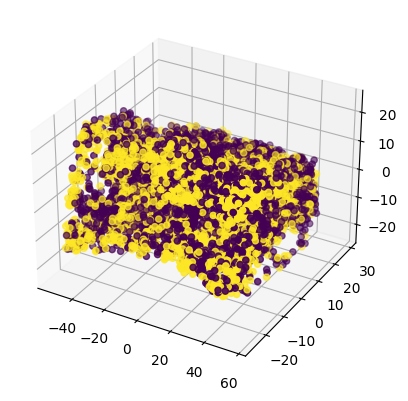

In [78]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.scatter(X_rain_train_isomap[:, 0], X_rain_train_isomap[:, 1], X_rain_train_isomap[:, 2], c=y_rain_train[:8000]);

In [82]:
isomap_rain = Isomap(n_components=2)
X_rain_train_isomap = isomap_rain.fit_transform(X_rain_train[:8000], y_rain_train[:8000])
X_rain_test_isomap = isomap_rain.transform(X_rain_test[:8000])

display(X_rain_train_isomap.shape, X_rain_test_isomap.shape)

test_rain(X_rain_train_isomap, y_rain_train[:8000], X_rain_test_isomap, y_rain_test[:8000]);

(8000, 2)

(8000, 2)

              precision    recall  f1-score   support

           0       0.53      0.60      0.56      4009
           1       0.54      0.48      0.51      3991

    accuracy                           0.54      8000
   macro avg       0.54      0.54      0.53      8000
weighted avg       0.54      0.54      0.53      8000



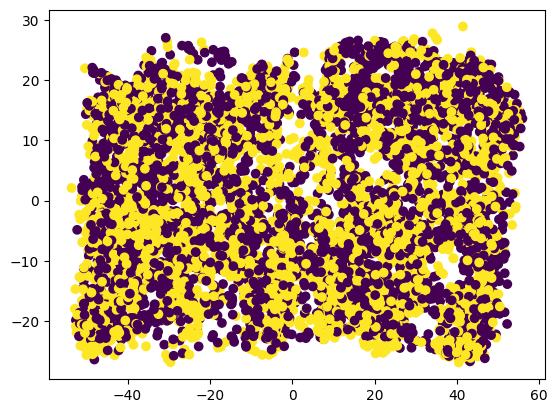

In [83]:
plt.scatter(X_rain_train_isomap[:, 0], X_rain_train_isomap[:, 1], c=y_rain_train[:8000]);

## PCA Home Edition

#### Для сравнения

(42715, 2)

(21039, 2)

              precision    recall  f1-score   support

           0       0.57      0.63      0.60     10520
           1       0.59      0.53      0.56     10519

    accuracy                           0.58     21039
   macro avg       0.58      0.58      0.58     21039
weighted avg       0.58      0.58      0.58     21039



0.862784400807637

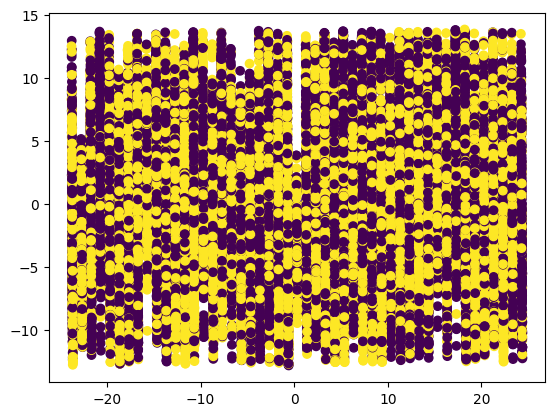

In [17]:
pca_rain = PCA(n_components=2)
X_rain_train_pca = pca_rain.fit_transform(X_rain_train, y_rain_train)
X_rain_test_pca = pca_rain.transform(X_rain_test)

display(X_rain_train_pca.shape, X_rain_test_pca.shape)

test_rain(X_rain_train_pca, y_rain_train, X_rain_test_pca, y_rain_test);

display(np.sum(pca_rain.explained_variance_ratio_))
plt.scatter(X_rain_train_pca[:, 0], X_rain_train_pca[:, 1], c=y_rain_train);

#### ☢️

In [12]:
from mylib.pca import PCA as PCAhe

In [15]:
pca_he_rain = PCAhe(n_components=2)
X_rain_train_pca_he = pca_he_rain.fit_transform(X_rain_train)
X_rain_test_pca_he = pca_he_rain.transform(X_rain_test)

display(X_rain_train_pca_he.shape, X_rain_test_pca_he.shape)

test_rain(X_rain_train_pca_he, y_rain_train, X_rain_test_pca_he, y_rain_test);

(42715, 2)

(21039, 2)

              precision    recall  f1-score   support

           0       0.55      0.62      0.59     10520
           1       0.57      0.49      0.53     10519

    accuracy                           0.56     21039
   macro avg       0.56      0.56      0.56     21039
weighted avg       0.56      0.56      0.56     21039



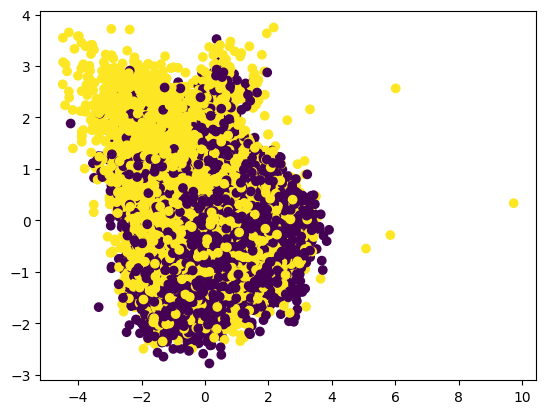

In [16]:
plt.scatter(X_rain_train_pca_he[:, 0], X_rain_train_pca_he[:, 1], c=y_rain_train);

## KMeans на пониженной размерности

In [20]:
from mylib.kmeans import KMeans

# внутренние
from sklearn.metrics import silhouette_score
from sklearn.metrics import davies_bouldin_score
# внешние
from sklearn.metrics.cluster import rand_score
from sklearn.metrics import fowlkes_mallows_score

In [21]:
def print_metrics(data, data_y, estimator_labels):
    print(
        f"""
= + = + = + = + Внешние метрики + = + = + = + =
{'rand_score':>23} = {rand_score(estimator_labels, data_y):.5f}\t (-> 1)
{'fowlkes_mallows_score':>23} = {fowlkes_mallows_score(estimator_labels, data_y):.5f}\t (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
{'silhouette_score':>23} = {silhouette_score(data, estimator_labels):.5f}\t (-> 1)
{'davies_bouldin_score':>23} = {davies_bouldin_score(data, estimator_labels):.5f}\t (-> 0)
"""
    )

In [19]:
kmeans1 = KMeans(n_clusters=2).fit(X_rain_train_pca_he)


= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.51488	 (-> 1)
  fowlkes_mallows_score = 0.51488	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.32255	 (-> 1)
   davies_bouldin_score = 1.17190	 (-> 0)



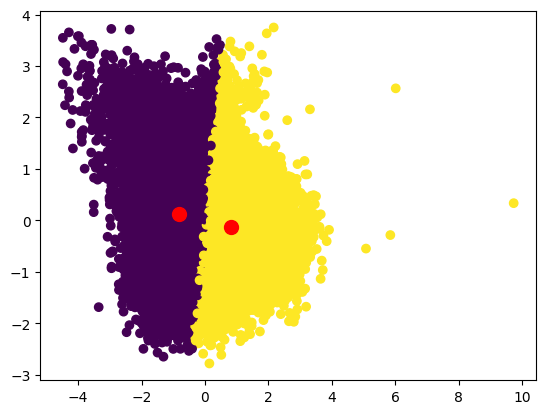

In [24]:
print_metrics(X_rain_train_pca_he, y_rain_train, kmeans1.labels_)

plt.scatter(X_rain_train_pca_he[:, 0], X_rain_train_pca_he[:, 1], c=kmeans1.labels_)
plt.scatter(kmeans1.cluster_centers_[:, 0], kmeans1.cluster_centers_[:, 1], s=100, c='red')


= + = + = + = + Внешние метрики + = + = + = + =
             rand_score = 0.62398	 (-> 1)
  fowlkes_mallows_score = 0.62630	 (-> 1)

= + = + = + = + Внутренние метрики + = + = + = + =
       silhouette_score = 0.32616	 (-> 1)
   davies_bouldin_score = 1.22003	 (-> 0)



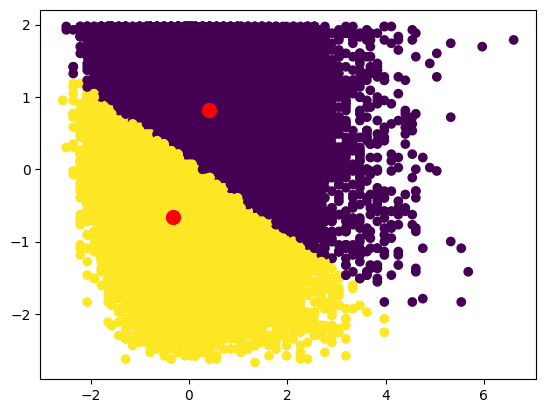

In [28]:
kmeans2 = KMeans(n_clusters=2).fit(X_rain_train_rfe)

print_metrics(X_rain_train_rfe, y_rain_train, kmeans2.labels_)

plt.scatter(X_rain_train_rfe[:, 0], X_rain_train_rfe[:, 1], c=kmeans2.labels_)
plt.scatter(kmeans2.cluster_centers_[:, 0], kmeans2.cluster_centers_[:, 1], s=100, c='red')

#### Для сравнения

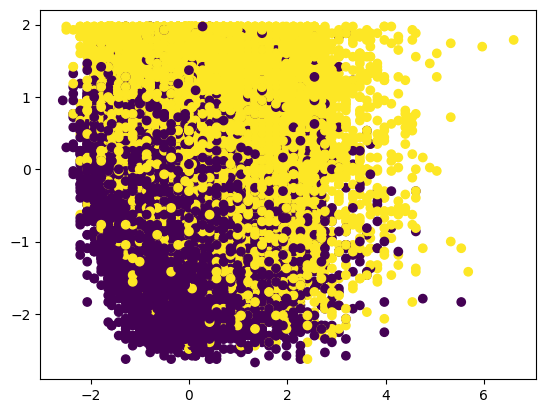

In [29]:
plt.scatter(X_rain_train_rfe[:, 0], X_rain_train_rfe[:, 1], c=y_rain_train);

## Пытка Ridge

In [13]:
from mylib.ridge import Ridge

from sklearn.metrics import r2_score

In [12]:
ridge = Ridge(X_wine_train, y_wine_train, 1, y_wine_test, X_wine_test)
ridge.fit()

In [19]:
r2_score(y_wine_test, ridge.predict(np.c_[np.ones(X_wine_test.shape[0]), X_wine_test]))

0.27730033690407174

In [21]:
ridge.w

array([ 6.10373947e+00, -8.22945071e-02,  1.36106002e-01,  8.04042081e-02,
        8.96619640e-02, -2.89271972e-02,  2.36070007e-01,  3.29622384e-01,
        1.07856258e-01, -3.71309112e-01, -5.73374334e-03, -2.37387804e-01,
       -3.81434039e-01])

Самый маленький коэф. = -5.73374334e-03. Некоторые похоже, что балансируют друг друга

Для отбора признаков таким образом лучше использовать регуляризатор L1 - Lasso, котоырй будет занулять несущественные признаки